In [3]:
# importing useful modules
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn import metrics
import numpy as np 
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
import pickle
from datetime import datetime
from pickle import dump
import mlflow
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
np.random.seed(40)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

In [5]:
# Load dataset
# df= pd.read_csv('../data/model_ready_data.csv')
df= pd.read_csv('../junk/model_ready_datav2.csv')
df.head(5)

,ER,CTR,all_text_word_count,LAR,all_objects_count,unique_objects_count,cta_text_word_count,cta_width,cta_height,red,green,blue,logo_width,logo_height,eng_width,eng_height,preview_width,preview_height
0,0.209269,0.058438,0.286957,0.000000,9,2,0.057143,0.052052,0.366577,0.090196,0.145098,0.098039,0.000000,0.000000,0.776667,0.085556,0.000000,0.000000
1,0.274552,0.074731,0.556522,0.000000,13,2,0.057143,0.052052,0.366577,0.090196,0.145098,0.098039,0.000000,0.000000,0.776667,0.085556,0.000000,0.000000
2,0.103688,0.042228,0.217391,0.000000,11,2,0.057143,0.038038,0.277628,0.090196,0.145098,0.098039,0.000000,0.000000,0.633333,0.070000,0.000000,0.000000
3,0.136963,0.005393,0.091304,0.078828,6,4,0.028571,0.067067,0.268194,0.584314,0.305882,0.254902,0.160738,0.193333,0.000000,0.000000,0.545051,0.350671
4,0.114208,0.016443,0.052174,0.123817,8,1,0.028571,0.048048,0.239892,0.501961,0.749020,0.996078,0.212780,0.127778,0.000000,0.000000,0.317259,0.335570


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ER                    905 non-null    float64
 1   CTR                   905 non-null    float64
 2   all_text              905 non-null    float64
 3   LAR                   905 non-null    float64
 4   all_objects_count     905 non-null    int64  
 5   unique_objects_count  905 non-null    int64  
 6   cta_text              905 non-null    float64
 7   cta_width             905 non-null    float64
 8   cta_height            905 non-null    float64
 9   red                   905 non-null    float64
 10  green                 905 non-null    float64
 11  blue                  905 non-null    float64
 12  logo_width            905 non-null    float64
 13  logo_height           905 non-null    float64
 14  eng_width             905 non-null    float64
 15  eng_height            9

In [8]:
## separate the independent and target variable 
X = df.drop(['ER','CTR'], axis = 1)
y = df['CTR']

In [9]:
X.head()

,all_text_word_count,LAR,all_objects_count,unique_objects_count,cta_text_word_count,cta_width,cta_height,red,green,blue,logo_width,logo_height,eng_width,eng_height,preview_width,preview_height
0,0.286957,0.000000,9,2,0.057143,0.052052,0.366577,0.090196,0.145098,0.098039,0.000000,0.000000,0.776667,0.085556,0.000000,0.000000
1,0.556522,0.000000,13,2,0.057143,0.052052,0.366577,0.090196,0.145098,0.098039,0.000000,0.000000,0.776667,0.085556,0.000000,0.000000
2,0.217391,0.000000,11,2,0.057143,0.038038,0.277628,0.090196,0.145098,0.098039,0.000000,0.000000,0.633333,0.070000,0.000000,0.000000
3,0.091304,0.078828,6,4,0.028571,0.067067,0.268194,0.584314,0.305882,0.254902,0.160738,0.193333,0.000000,0.000000,0.545051,0.350671
4,0.052174,0.123817,8,1,0.028571,0.048048,0.239892,0.501961,0.749020,0.996078,0.212780,0.127778,0.000000,0.000000,0.317259,0.335570


In [10]:
# Splitting our dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print ("Training and testing split was successful.")

Training and testing split was successful.


In [11]:
# Define the Pipeline
model_pipeline = Pipeline(steps=[('random_forest', RandomForestRegressor(max_depth=10,random_state=2))])

In [12]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    print("RMSE Score is: {:.5%}".format(rmse))
    print("R2 Square Score is: {:.5%}".format(r2))
    print("MAE Score is: {:.5%}".format(mae))
    return {f'RMSE Score': rmse, f'R2_Squared': r2, f'MAE Score': mae}

In [13]:
sc = StandardScaler()
sc.fit(X_test)
## x = sc.transform(X)

StandardScaler()

In [14]:
# Fit the pipeline with the data
mlflow.autolog(log_input_examples=True, disable_for_unsupported_versions=True, silent=True)
with mlflow.start_run() as run:
    best_model = model_pipeline.fit(X_train, y_train)

    train_score = best_model.score(X_train, y_train)
    valid_score = best_model.score(X_valid, y_valid)
    valid_metrics = eval_metrics(y_valid, best_model.predict(X_valid))
    test_score = best_model.score(X_test, y_test)
    test_metrics = eval_metrics(y_test, best_model.predict(X_test))

    mlflow.log_metric("Valid Score", valid_score)
    mlflow.log_metrics(valid_metrics)
    mlflow.log_metric("Test Score", test_score)
    mlflow.log_metrics(test_metrics)

RMSE Score is: 2.74029%
R2 Square Score is: 27.57909%
MAE Score is: 1.78312%
RMSE Score is: 3.07397%
R2 Square Score is: 21.42176%
MAE Score is: 2.03418%


In [15]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [{
     'random_forest': [RandomForestRegressor(max_depth=10, random_state=2)],
     'random_forest__bootstrap': [True, True],
     'random_forest__ccp_alpha': [0.0],
     'random_forest__criterion': ['mse'],
     'random_forest__max_depth': [5,8,15],
     'random_forest__max_features': ['auto'],
#      'random_forest__max_leaf_nodes': None,
#      'random_forest__max_samples': None,
     'random_forest__min_impurity_decrease': [0.0],
#      'random_forest__min_impurity_split': None,
     'random_forest__min_samples_leaf': [1,5],
     'random_forest__min_samples_split': [2],
     'random_forest__min_weight_fraction_leaf': [0.0],
     'random_forest__n_estimators': [100],
#      'random_forest__n_jobs': None,
     'random_forest__oob_score': [False, True],
     'random_forest__random_state': [2],
     'random_forest__verbose': [0],
     'random_forest__warm_start': [True, False]
}]

    
# create a gridsearch of the pipeline, the fit the best model
grid_search_pipeline = GridSearchCV(
    model_pipeline, grid_param, cv=3, verbose=0, n_jobs=-1)  # Fit grid search

In [16]:
def generate_model_name(mse_score: float) -> str:
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M-%S-")
    dt_string = dt_string + "{:.2%}".format(mse_score)
    return dt_string

In [17]:
valid_metrics


{'RMSE Score': 0.027402920861379097,
 'R2_Squared': 0.27579087369062283,
 'MAE Score': 0.017831185959307678}

In [18]:
test_metrics


{'RMSE Score': 0.03073970509418748,
 'R2_Squared': 0.21421761345187973,
 'MAE Score': 0.0203418017651158}

In [19]:
def save_model(model, mse_score) -> None:
    try:
        file_name = '../models/' + generate_model_name(mse_score=mse_score) +'.pkl'
        with open(file_name, 'wb') as handle:
            dump(model, handle)
    except Exception as e:
        print('Error while producing model')

In [21]:
save_model(best_model, test_metrics['RMSE Score'])

In [22]:
best_model.get_params()

{'memory': None,
 'steps': [('random_forest',
   RandomForestRegressor(max_depth=10, random_state=2))],
 'verbose': False,
 'random_forest': RandomForestRegressor(max_depth=10, random_state=2),
 'random_forest__bootstrap': True,
 'random_forest__ccp_alpha': 0.0,
 'random_forest__criterion': 'squared_error',
 'random_forest__max_depth': 10,
 'random_forest__max_features': 1.0,
 'random_forest__max_leaf_nodes': None,
 'random_forest__max_samples': None,
 'random_forest__min_impurity_decrease': 0.0,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2,
 'random_forest__min_weight_fraction_leaf': 0.0,
 'random_forest__n_estimators': 100,
 'random_forest__n_jobs': None,
 'random_forest__oob_score': False,
 'random_forest__random_state': 2,
 'random_forest__verbose': 0,
 'random_forest__warm_start': False}

<AxesSubplot: >

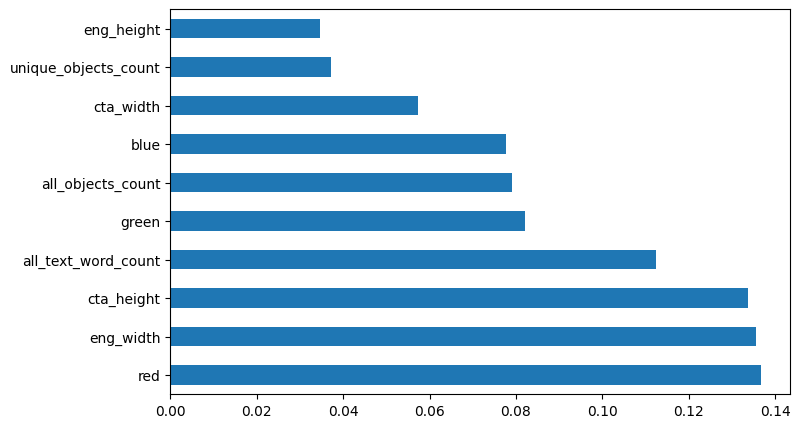

In [25]:
plt.figure(figsize=(8,5))
feat_importances = pd.Series(best_model.steps[0][1].feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [69]:
df_=df.sample()
X_ = df_.drop(['ER','CTR'], axis = 1)
y_ = df_['CTR']
y_pred = best_model.predict(X_)

In [70]:
print(f"predicted {y_pred[0]}")
print(f"truth value {y_.values[0]}")

predicted 0.03740164799880733
truth value 0.0306920373684899
